In [1]:
!pip install torch
!pip install pandas
!pip install transformers
!pip install tqdm
!pip install matplotlib


In [1]:
import torch
import pandas as pd
import torch.nn as nn 
from torch.utils.data._utils.collate import default_collate
import numpy as np 
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt 
import os

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_df = pd.read_csv('/kaggle/input/deepakrana-sentimentanalysisdataset/balanced_dataset.csv')
test_df = pd.read_csv('/kaggle/input/deepakrana-sentimentanalysisdataset/preprocessed_test_final.csv')
 

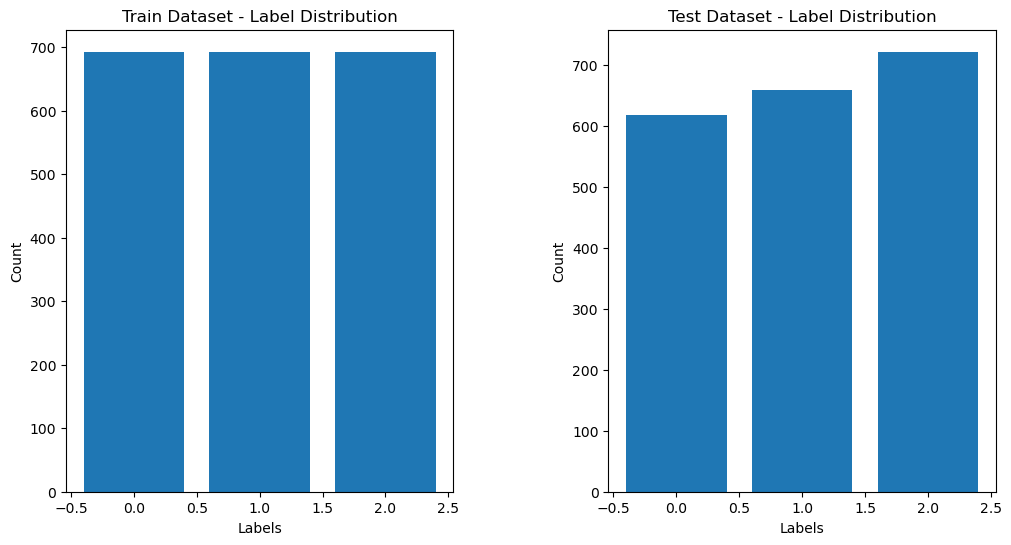

In [3]:
# Bar graph for train dataset
train_labels = train_df['label'].value_counts()

# Bar graph for test dataset
test_labels = test_df['label'].value_counts()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train dataset subplot
axs[0].bar(train_labels.index, train_labels.values)
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Count')
axs[0].set_title('Train Dataset - Label Distribution')

# Test dataset subplot
axs[1].bar(test_labels.index, test_labels.values)
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Count')
axs[1].set_title('Test Dataset - Label Distribution')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [5]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [6]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
train_dataset = SentimentDataset(train_df['text'], train_df['label'], tokenizer, max_len=128)
test_dataset = SentimentDataset(test_df['text'], test_df['label'], tokenizer, max_len=128)

In [8]:
train_dataset[:5]

{'input_ids': tensor([  101,  1014,   100,  1319, 29874, 29859, 29879,  1339, 29876, 29870,
         29867, 29876,   100,   100,  1323, 29868, 29876, 29875, 29877,  1339,
         29876, 29870,  1313, 29863, 29851, 29879,  1012,  1012,  1012,  1015,
          1315,   100,  1040, 10258,  2361,  1315, 29879,  1329, 29876, 29869,
         29867, 29876,  1311, 29870, 29877, 29851, 29859, 29877,  1329, 29863,
         29863,   100,  1029,  1016,  1339, 29879,   100,  1017,  1332, 29874,
         29859,   100,   100,  1323,  1339, 29879, 29863, 29878,  1338, 29867,
         29876, 29859, 29863,  1018,  1331, 29869, 29852, 29859, 29876,  1339,
         29879,  2171,  1024,  3793,  1010, 26718, 18863,  1024,  4874,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
train_dataloader


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()


True

In [12]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, no_deprecation_warning = True)


In [14]:
num_epochs = 10
train_steps = int(len(train_dataloader) * 0.1)
loss_values = []
accuracy_values = []


In [17]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(total=train_steps, desc="Training")
    for batch in train_dataloader:
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()


        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        progress_bar.set_postfix({'Loss': loss.item()})
        progress_bar.update(1)
    average_loss = total_loss / len(train_dataloader)
    loss_values.append(average_loss)
    progress_bar.close()
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {average_loss:.4f}')

    model.eval()
    predictions = []
    true_labels = []
    progress_bar = tqdm(total=len(test_dataloader), desc="Testing")

    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)

            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        progress_bar.update(1)
    progress_bar.close()
    accuracy = accuracy_score(true_labels, predictions)
    accuracy_values.append(accuracy)

    print(f'Test Accuracy: {accuracy:.4f}')

    report = classification_report(true_labels, predictions)
    print(report)

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 0.1211


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9780
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       618
           1       0.98      0.99      0.98       660
           2       0.98      0.98      0.98       722

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/10 - Loss: 0.1075


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9840
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       618
           1       0.99      1.00      0.99       660
           2       1.00      0.96      0.98       722

    accuracy                           0.98      2000
   macro avg       0.98      0.99      0.98      2000
weighted avg       0.98      0.98      0.98      2000



Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/10 - Loss: 0.1226


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9855
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       618
           1       0.98      1.00      0.99       660
           2       1.00      0.97      0.98       722

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/10 - Loss: 0.1199


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9795
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       618
           1       0.97      1.00      0.98       660
           2       0.99      0.96      0.98       722

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/10 - Loss: 0.1067


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9935
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       618
           1       1.00      1.00      1.00       660
           2       0.99      0.99      0.99       722

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6/10 - Loss: 0.1019


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9965
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       618
           1       1.00      1.00      1.00       660
           2       0.99      1.00      1.00       722

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/10 - Loss: 0.0979


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9895
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       618
           1       1.00      1.00      1.00       660
           2       0.99      0.98      0.99       722

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/10 - Loss: 0.0961


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9830
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       618
           1       0.99      1.00      0.99       660
           2       0.99      0.96      0.98       722

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9/10 - Loss: 0.0737


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9845
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       618
           1       1.00      0.99      0.99       660
           2       0.98      0.98      0.98       722

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



Training:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/10 - Loss: 0.0974


Testing:   0%|          | 0/125 [00:00<?, ?it/s]

Test Accuracy: 0.9880
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       618
           1       1.00      0.99      0.99       660
           2       0.99      0.98      0.98       722

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [20]:
import shutil
import zipfile

# Define the paths
output_directory = '/kaggle/working/nepali_trained_model'

# Save the pre-trained model and tokenizer
model.save_pretrained(output_directory)
tokenizer.save_pretrained(output_directory)

# Create a zip file of the output directory
shutil.make_archive(output_directory, 'zip', output_directory)

# Define the zip file name
zip_filename = f'{output_directory}.zip'

# Download the zip file
with open(zip_filename, 'rb') as f:
    zip_data = f.read()


ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

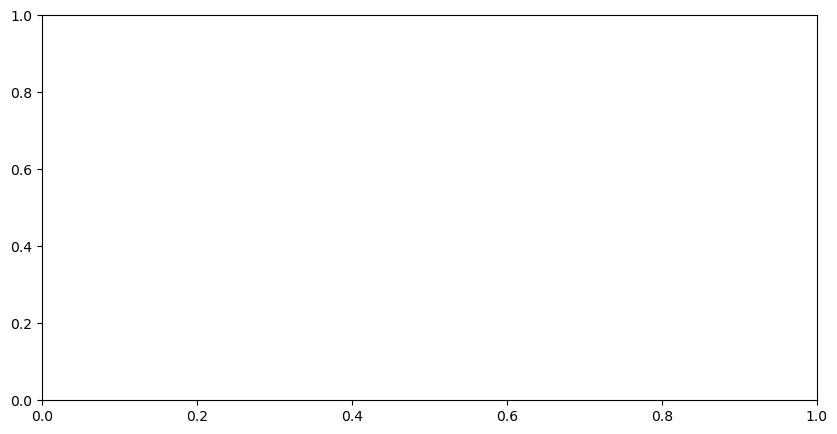

In [39]:

# Plotting Loss and Accuracy
epochs = range(1, num_epochs+1)

# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the graph
plt.savefig('/kaggle/working/Loss_value.png')

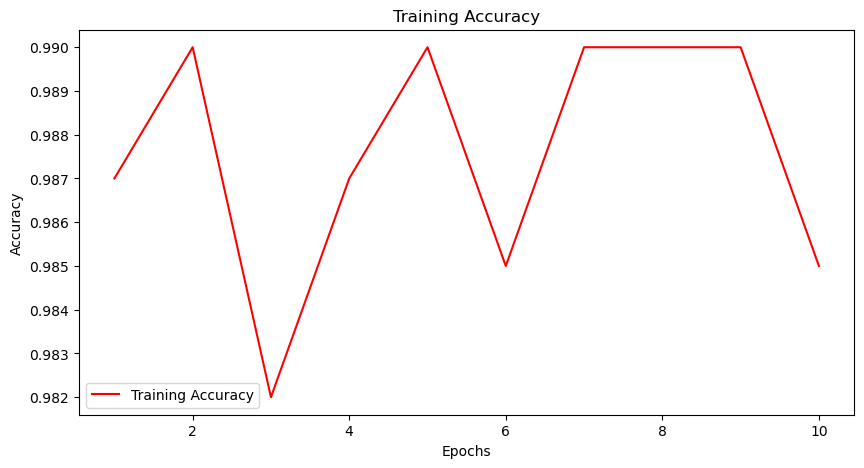

<Figure size 640x480 with 0 Axes>

In [35]:
# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_values, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Save the graph
plt.savefig('/kaggle/working/accuracy_value.png')